<a href="https://colab.research.google.com/github/amir-asari/VLM_Bootcamp/blob/main/QWEN_learnopencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://learnopencv.com/object-detection-with-vlms-ft-qwen2-5-vl/

###Part 1: Setting the Stage – Loading the Model and Processor
Before our assembly line can start working, we need to set up our main machinery. This involves loading the Qwen2.5-VL model itself and a special helper called a “processor.”

In [2]:
!pip install supervision
!pip install gradio
import json
import time

import gradio as gr
import numpy as np
from PIL import Image
!pip install qwen_vl_utils
from qwen_vl_utils import process_vision_info

In [3]:
from transformers import (
    AutoProcessor,
    Qwen2_5_VLForConditionalGeneration,
)


# --- Config ---
model_qwen_id = "Qwen/Qwen2.5-VL-3B-Instruct"

# Load the main model
model_qwen = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_qwen_id, torch_dtype="auto", device_map="auto"
)

# Load the processor
min_pixels = 224 * 224
max_pixels = 1024 * 1024
processor_qwen = AutoProcessor.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.




*   The Model (Qwen2_5_VLForConditionalGeneration): This is the brain of the operation. The from_pretrained function fetches the 3-billion parameter version of Qwen2.5-VL from the Hugging Face Hub. The arguments torch_dtype="auto" and device_map="auto" are for efficiency, telling the library to use the best data format and automatically place the model on a GPU if one is available.
*   The Processor (AutoProcessor): If the model is the brain, the processor is the sensory system. Its job is to take our raw image and text and convert them into a format the model can understand. Notice the min_pixels and max_pixels settings. This is where we leverage Qwen’s native dynamic resolution. We’re telling the processor that it can handle images of various sizes within this range, avoiding the detail loss that comes with forced resizing.



###Part 2: The Main Event – The Inference Function (detect_qwen)
This is the core of our assembly line, where the image and prompt are processed and sent to the model for analysis. We’ll look at this function step-by-step.

In [13]:
# @ GPU <- this is disable as original code run using GPU from huggingface
def detect_qwen(image, prompt):
  # Step 1: Format the inputs
  messages = [
      {
          "role": "user",
          "content": [
              {"type": "image", "image": image},
              {"type": "text", "text": prompt},
          ],
      }
  ]
  t0 = time.perf_counter()
  # Step 2: Preprocess with the processor
  text = processor_qwen.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor_qwen(
        text=[text],
        images=image_inputs,
        # ...
        return_tensors="pt",
  ).to(model_qwen.device)

  # Step 3: Run inference
  generated_ids = model_qwen.generate(**inputs, max_new_tokens=1024)
  generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]


  # Step 4: Decode the output
  # ... (trimming and decoding logic)
  output_text = processor_qwen.batch_decode(
      generated_ids_trimmed,
      do_sample=True,
      skip_special_tokens=True,
      clean_up_tokenization_spaces=False,
  )[0]
  elapsed_ms = (time.perf_counter() - t0) * 1_000

  # Step 5: Get processed dimensions for scaling
  input_height = inputs["image_grid_thw"][0][1] * 14
  input_width = inputs["image_grid_thw"][0][2] * 14

  # Step 6: Create the annotated image
  annotated_image = create_annotated_image(image, output_text, input_height, input_width)

  time_taken = f"**Inference time ({model_qwen_name}):** {elapsed_ms:.0f} ms"
  return annotated_image, output_text, time_taken


def detect(image, prompt):
    STANDARD_SIZE = (1024, 1024)
    image.thumbnail(STANDARD_SIZE)

    annotated_image, output_text, time_taken = detect_qwen(image, prompt)

    return (
      annotated_image,
      output_text,
      time_taken,
    )



*   Step 1: Format the Inputs: We package our image and prompt into a messages list. This structured format is exactly how the model expects to receive multimodal (image + text) data. It’s clean and mimics a conversational turn.
*   Step 2: Preprocess: Here, the processor earns its keep. It takes the messages list and performs several crucial actions: it applies a chat template to the text, processes the image into a grid of patches, and bundles everything into tensors, the numerical format that models work with.
*   Step 3: Run Inference: This is the moment of magic. model_qwen.generate(**inputs) sends the prepared data to the model. The model “looks” at the image tensor, “reads” the text tensor, and generates a sequence of output tokens that represent its answer.
* Step 4: Decode the Output: The model’s raw output is a sequence of token IDs. The processor.batch_decode function translates these numbers back into human-readable text, giving us the JSON string we asked for in our prompt.
* Step 5: Get Processed Dimensions: This is a subtle but critical step for accurate visualization. The model doesn’t see the image in pixels; it sees it as a grid of 14×14 pixel patches. This line retrieves the dimensions of that grid (inputs['image_grid_thw']) and multiplies by 14 to get the total dimensions of the image as the model saw it. We need these dimensions to correctly scale the bounding box coordinates later.
* Step 6: Annotate: Finally, we pass everything to our visualization function, which we’ll explore next.








###Part 3: The Finishing Touch – Visualizing the Results (create_annotated_image)
The model gives us data; this function turns that data into insight. It parses the model’s JSON response and draws the bounding boxes and keypoints directly onto our original image.


In [15]:
import supervision as sv
def create_annotated_image(image, json_data, height, width):
    try:
        parsed_json_data = json_data.split("```json")[1].split("```")[0]
        bbox_data = json.loads(parsed_json_data)
    except Exception:
        return image

    original_width, original_height = image.size
    x_scale = original_width / width
    y_scale = original_height / height

    points = []
    point_labels = []

    for item in bbox_data:
        label = item.get("label", "")
        if "point_2d" in item:
            x, y = item["point_2d"]
            scaled_x = int(x * x_scale)
            scaled_y = int(y * y_scale)
            points.append([scaled_x, scaled_y])
            point_labels.append(label)

        annotated_image = np.array(image.convert("RGB"))

        detections = sv.Detections.from_vlm(
            vlm=sv.VLM.QWEN_2_5_VL,
            result=json_data,
            input_wh=(original_width, original_height),
            resolution_wh=(original_width, original_height),
        )
        bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
        label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

        annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    if points:
        points_array = np.array(points).reshape(1, -1, 2)
        key_points = sv.KeyPoints(xy=points_array)
        vertex_annotator = sv.VertexAnnotator(radius=5, color=sv.Color.BLUE)
        # vertex_label_annotator = sv.VertexLabelAnnotator(text_scale=0.5, border_radius=2)

        annotated_image = vertex_annotator.annotate(scene=annotated_image, key_points=key_points)

        # annotated_image = vertex_label_annotator.annotate(
        #     scene=annotated_image,
        #     key_points=key_points,
        #     labels=point_labels
        # )

    return Image.fromarray(annotated_image)


  * Step 1: Parse the JSON: The model often wraps its JSON output in markdown-style code blocks (json ...). This code first cleans that up and then uses json.loads to convert the text into a usable Python list of objects. The try-except block is good practice to prevent the app from crashing if the model returns a non-JSON response.
  * Step 2: Visualize with supervision: Manually drawing boxes and labels can be tedious. The supervision library is a fantastic toolkit that massively simplifies this.
    *  sv.Detections.from_vlm(...): This is the star of the show. The library has built-in support for parsing the output of Qwen2.5-VL! We just pass it the raw JSON response (result) and the dimensions the model used (resolution_wh). It automatically handles the coordinate scaling and creates a Detections object.
    * sv.BoxAnnotator and sv.LabelAnnotator: These are helpers that take the Detections object and, with a single line of code, draw the boxes and labels onto our image.

This pipeline is a beautiful example of modern machine learning engineering. We use a powerful foundation model, guide it with a clear prompt, and then leverage high-level libraries like supervision to quickly build a robust and useful application around it. This entire workflow perfectly demonstrates the practical side of Object Understanding with VLMs.

##Inference
We’ve explored the theory, dissected the code, and compared the philosophies of our two models. Now, it’s curtain time. This is where we step into the director’s chair, give our models their prompts, and see how they perform on a live stage. The following examples showcase the incredible versatility of these VLMs, moving seamlessly between different types of visual understanding based on nothing more than the words we use.

We have created a Gradio interface for you to interact with the model and experiment with different images.

In [10]:
def extract_model_short_name(model_id):
    return model_id.split("/")[-1].replace("-", " ").replace("_", " ")


model_qwen_name = extract_model_short_name(model_qwen_id)  # → "Qwen2.5 VL 3B Instruct"

In [7]:
css_hide_share = """
button#gradio-share-link-button-0 {
    display: none !important;
}
"""

# --- Gradio Interface ---
with gr.Blocks(theme=gr.themes.Soft(), css=css_hide_share) as demo:
    gr.Markdown("# Object Detection & Understanding with Vision Language Models")
    gr.Markdown(
        "### Explore object detection, visual grounding, keypoint detection, and/or object counting through natural language prompts."
    )
    gr.Markdown(
        """
    *Powered by [Qwen2.5-VL 3B](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct). Inspired by the [HF Team's space](https://huggingface.co/spaces/sergiopaniego/vlm_object_understanding).*
    """
    )

    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(label="Upload an image", type="pil", height=400)
            prompt_input = gr.Textbox(
                label=f"Enter your prompt for {model_qwen_name}",
                placeholder="e.g., Detect all red cars in the image",
            )
            generate_btn = gr.Button(value="Generate")

        with gr.Column(scale=1):
            output_image = gr.Image(type="pil", label=f"Annotated image from {model_qwen_name}", height=400)
            output_textbox = gr.Textbox(label=f"Model response from {model_qwen_name}", lines=10)
            output_time = gr.Markdown()

    gr.Markdown("### Examples")
    example_prompts = [
        [
            "examples/example_1.jpg",
            "Detect all objects in the image and return their locations and labels.",
        ],
        [
            "examples/example_2.jpg",
            "Detect all the individual candies in the image and return their locations and labels.",
        ],
        [
            "examples/example_1.jpg",
            "Count the number of red cars in the image.",
        ],
        [
            "examples/example_2.jpg",
            "Count the number of blue candies in the image.",
        ],
        [
            "examples/example_1.jpg",
            "Identify the red cars in this image, detect their key points and return their positions in the form of points.",
        ],
        [
            "examples/example_2.jpg",
            "Identify the blue candies in this image, detect their key points and return their positions in the form of points.",
        ],
        [
            "examples/example_1.jpg",
            "Detect the red car that is leading in this image and return its location and label.",
        ],
        [
            "examples/example_2.jpg",
            "Detect the blue candy located at the top of the group in this image and return its location and label.",
        ],
    ]

    gr.Examples(
        examples=example_prompts,
        inputs=[
            image_input,
            prompt_input,
        ],
        label="Click an example to populate the input",
    )

    generate_btn.click(
        fn=detect,
        inputs=[
            image_input,
            prompt_input,
        ],
        outputs=[
            output_image,
            output_textbox,
            output_time,
        ],
    )

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0d661572b0b38065e1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


https://github.com/spmallick/learnopencv/tree/master/object-detection-with-vlms


Output Text:
```json
[
	{"bbox_2d": [269, 425, 351, 470], "label": "eyes"},
	{"bbox_2d": [448, 425, 518, 467], "label": "eyes"}
]
```

Time Taken:
**Inference time (Qwen2.5 VL 3B Instruct):** 9592 ms

Annotated Image:


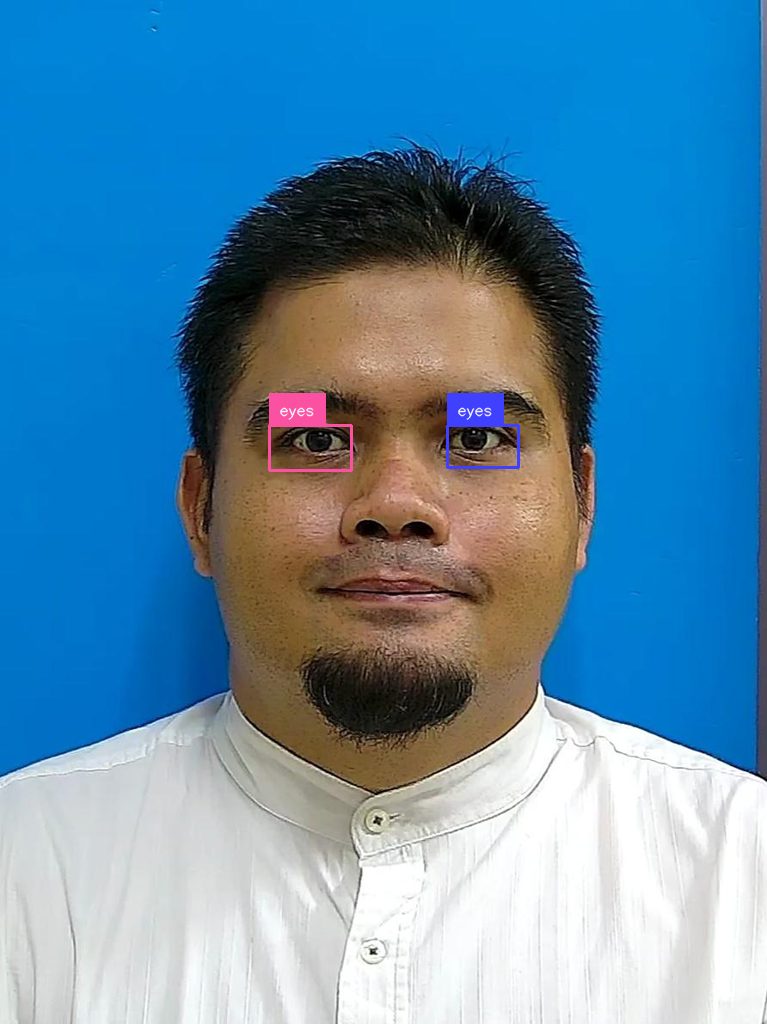

In [16]:
from PIL import Image

# Define the image path and prompt
image_path = "/content/image.jpg"  # Replace with your image path
prompt = "Detect eyes in the image." # Replace with your prompt

# Load the image
try:
    image = Image.open(image_path)
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    exit()

# Define model_qwen_name
model_qwen_name = extract_model_short_name(model_qwen_id)

# Call the detect function
# Note: The detect function expects a PIL Image object
annotated_image, output_text, time_taken = detect(image, prompt)

# Display the results
print("Output Text:")
print(output_text)
print("\nTime Taken:")
print(time_taken)

# Display the annotated image
print("\nAnnotated Image:")
display(annotated_image)